In [568]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler

In [569]:
data = pd.read_csv("kickstarter.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100

In [570]:
def del_n_sigmas_emissions(df, col_name, n_sigmas=3) -> DataFrame:
    len_was = df.shape[0]
    std = df[col_name].std()
    mean = df[col_name].mean()
    result = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
    #print(f'{col_name}: {len_was - result.shape[0]} lines deleted')
    return result    

In [571]:
df = data.copy()

# Using 3 sigmas rule
df = del_n_sigmas_emissions(df, 'created')
df = del_n_sigmas_emissions(df, 'n_pled_t')
df = del_n_sigmas_emissions(df, 'goal')
df = del_n_sigmas_emissions(df, 'period')
#draw_scatter(df, 'goal')
len_was = df.shape[0]
df = df[df['goal'] > 15]
#print('goal < 15:', len_was - df.shape[0])
df = del_n_sigmas_emissions(df, 'success_rate')
df = del_n_sigmas_emissions(df, 'mgp')
df = del_n_sigmas_emissions(df, 'n_img')

In [572]:
df["text_am_2"] = df["text_am"] ** 2
df["n_img_2"] = df["n_img"] ** 2
df["n_vid_2"] = df["n_vid"] ** 2
df["created_2"] = df["created"] ** 2
df["cont_2"] = df["cont"] ** 2
df["mgp_2"] = df["mgp"] ** 2
df["n_pled_t_2"] = df["n_pled_t"] ** 2
df["period_2"] = df["period"] ** 2
df["step_pled_t_2"] = df["step_pled_t"] ** 2
df['bias'] = np.ones((df.shape[0]))

In [573]:
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure']

In [574]:
our = ['text_am', 'text_am_2', 'n_vid', 'cont', 'mgp', 'n_vid_2', 'mgp_2', 'cont_2', 'n_img_2', 'n_img']
# step_pled_t_2 и n_img_2 имеют полоэительные коэффиценты

In [575]:
result = our + binary_columns

In [576]:
X = df[our]
Y = df["success_rate"]

scaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size=0.8, 
                                                    random_state=42)

train_data = scaler.fit_transform(X_train)
test_x_data = scaler.transform(X_test)
test_y_data = Y_test

In [577]:
ols = sm.OLS(df['success_rate'], df[our])
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           success_rate   R-squared (uncentered):                   0.371
Model:                            OLS   Adj. R-squared (uncentered):              0.370
Method:                 Least Squares   F-statistic:                              452.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                        0.00
Time:                        13:47:01   Log-Likelihood:                         -44084.
No. Observations:                7692   AIC:                                  8.819e+04
Df Residuals:                    7682   BIC:                                  8.826e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
text_am        0.0100      0.003      3.584      0.000       0.005       0.015
text_am_2    -1.5e-06   7.14e-07     -2.100      0.036    -2.9e-06   -9.97e-08
n_vid         38.6166      1.302     29.657      0.000      36.064      41.169
cont          75.9569     20.534      3.699      0.000      35.705     116.209
mgp           10.1572      1.657      6.128      0.000       6.908      13.406
n_vid_2       -3.5614      0.178    -19.970      0.000      -3.911      -3.212
mgp_2         -0.6060      0.117     -5.164      0.000      -0.836      -0.376
cont_2       -27.2078     47.574     -0.572      0.567    -120.466      66.051
n_img_2        0.0228      0.006      3.516      0.000       0.010       0.036
n_img         -1.8681      0.384     -4.862      0.000      -2.621      -1.115
==============================================================================
Omnibus:                     5533.081   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106339.459
Skew:                           3.278   Prob(JB):                         0.00
Kurtosis:                      19.995   Cond. No.                     2.22e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [578]:
#for col in ['text_am', 'n_vid', 'mgp']:
    #col_sqr = col + '_2'
    #def func(x):
        #return summary_df['coef'][col] * x + summary_df['coef'][col_sqr] * x ** 2

    #plt.figure(figsize=(14,10))
    #plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00', 
         #lw=2,
         #linestyle='-')
    #plt.scatter(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00')
    #plt.xlabel(f'Значение {col}', fontsize=20)
    #plt.ylabel(f'Значение success_rate в %', fontsize=20)
#summary_df['coef']

text_am       0.010000
text_am_2    -0.000002
n_vid        38.616600
cont         75.956900
mgp          10.157200
n_vid_2      -3.561400
mgp_2        -0.606000
cont_2      -27.207800
n_img_2       0.022800
n_img        -1.868100
Name: coef, dtype: float64

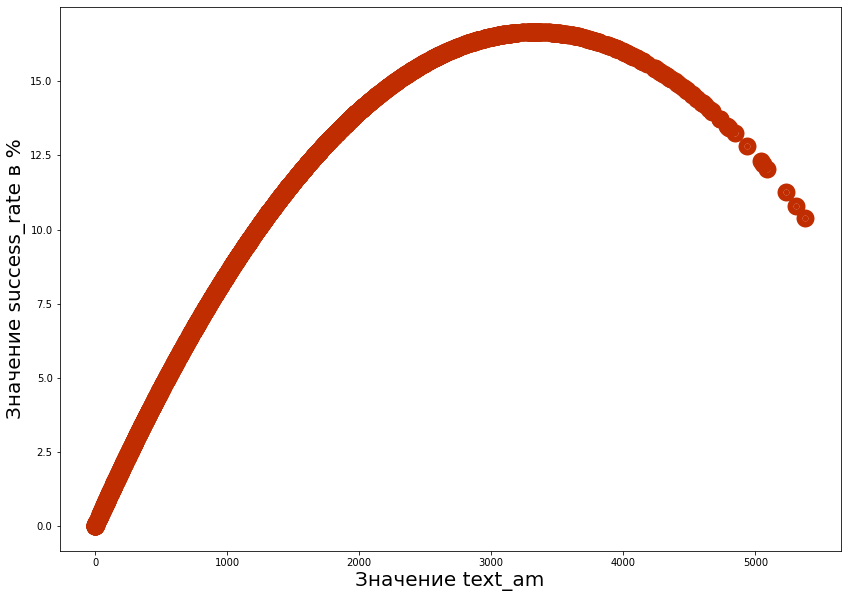

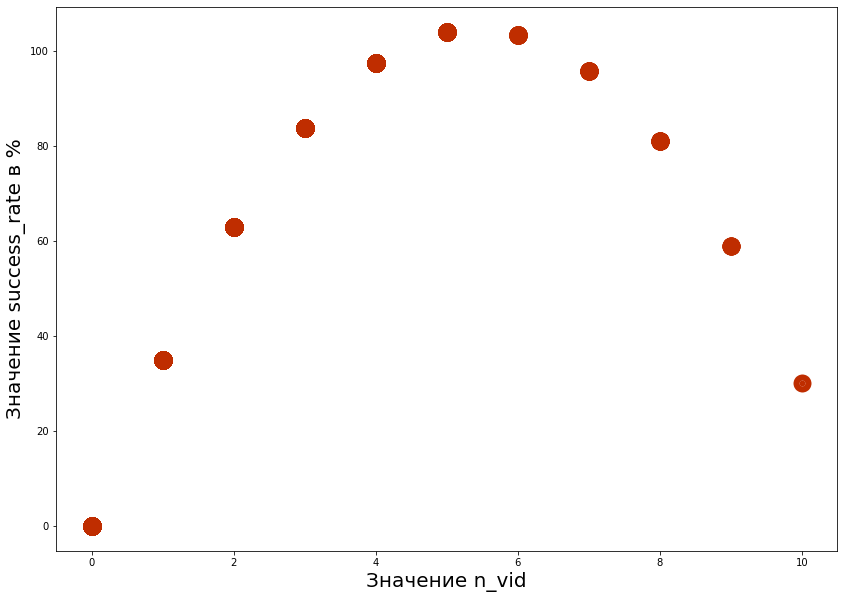

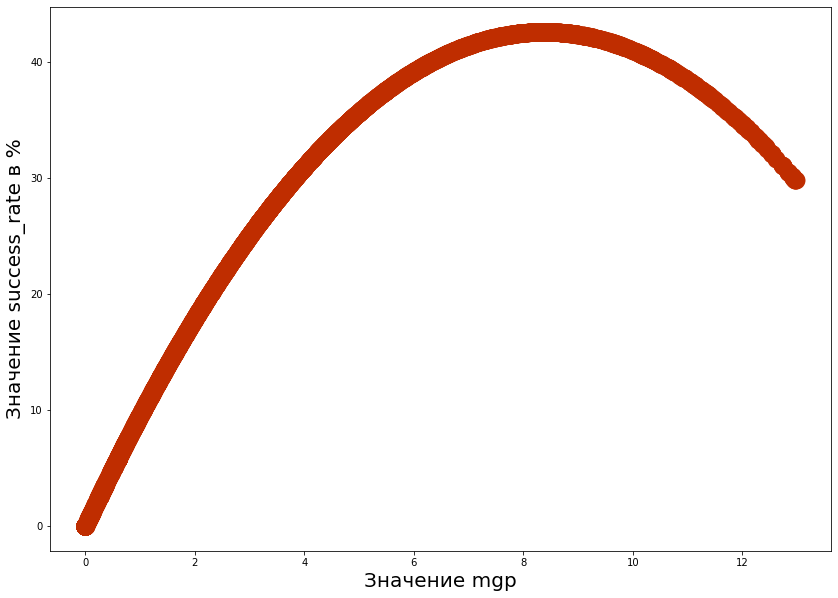

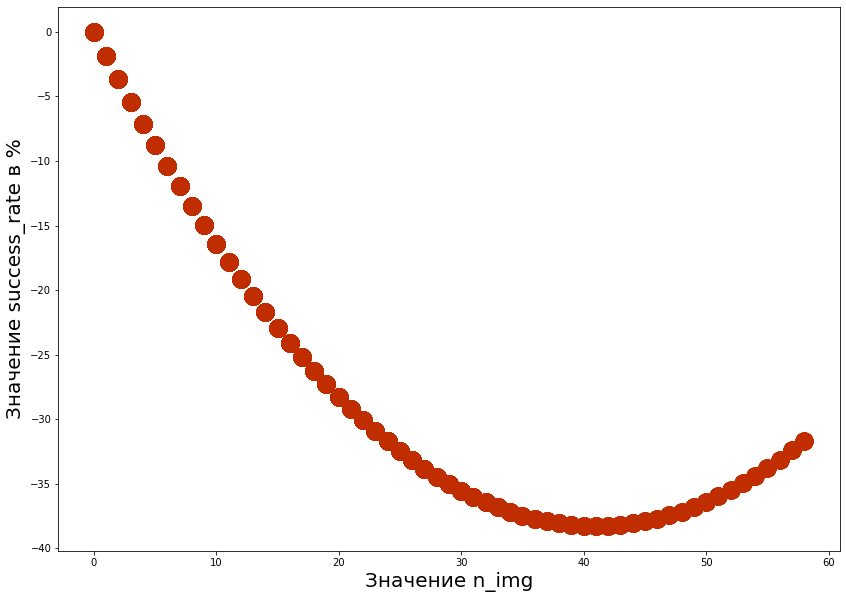

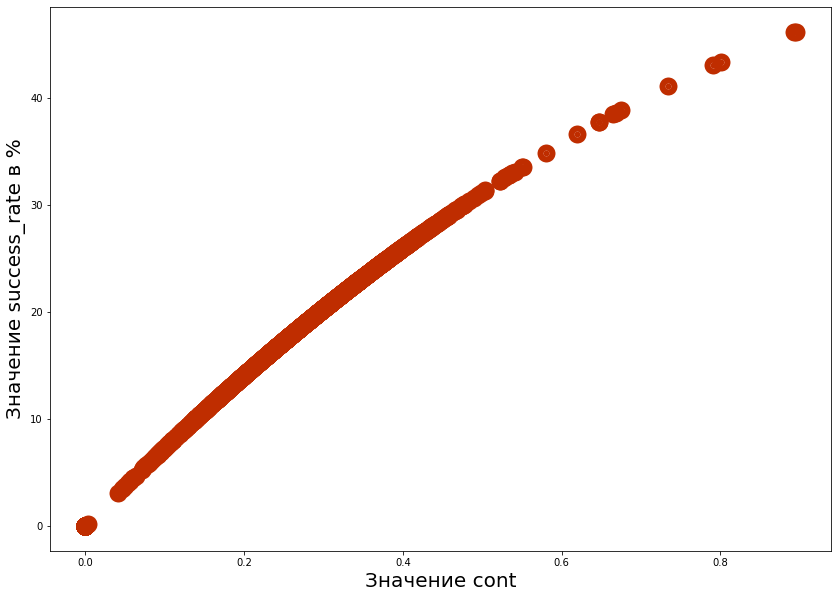

In [579]:
df["text_am"] = df[df["text_am"] < 5500]["text_am"]
df["n_vid"] = df[df["n_vid"] < 11]["n_vid"]
df["mgp"] = df[df["mgp"] < 13]["mgp"]

for col in ['text_am', 'n_vid', 'mgp', "n_img", "cont"]:
    col_sqr = col + '_2'
    def func(x):
        return summary_df['coef'][col] * x + summary_df['coef'][col_sqr] * x ** 2

    plt.figure(figsize=(14,10))
    #plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00', 
         #lw=2,
         #linestyle='-')
    plt.scatter(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         color='#BF2D00', linewidths = 12)
    plt.xlabel(f'Значение {col}', fontsize=20)
    plt.ylabel(f'Значение success_rate в %', fontsize=20)
summary_df['coef']